In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from utils import *

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

In [2]:
import kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files('Perrin Freres Monthly Champagne Sales', path='../data', unzip=True)

OSError: Could not find kaggle.json. Make sure it's located in C:\Users\PAC\.kaggle. Or use the environment method.

## Dataset 

In [77]:
data_dir = 'C:/Users/Antonin_Joly/Desktop'
data = pd.read_csv(os.path.join(data_dir,'perrin-freres-monthly-champagne.csv')).dropna(axis=0)
data.columns = ["Date", "Sale"]
data['Date'] = pd.to_datetime(data['Date'])
data["rolling_avg"] = data["Sale"].rolling(window=12).mean()
data["rolling_std"] = data["Sale"].rolling(window=12).std()
data = data.set_index('Date')

df, df_test = data.iloc[:int(0.85*data.shape[0]), :], data.iloc[int(0.85*data.shape[0])-1:, :]

data.head()

,Sale,rolling_avg,rolling_std
Date,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,NaN,NaN
1964-03-01,2755.0,NaN,NaN
1964-04-01,2721.0,NaN,NaN
1964-05-01,2946.0,NaN,NaN


## SALES DATA BEHAVIOR VISUALIZATION

In [78]:
ssn = seasonal_decompose(data['Sale'], model="additive", period=12)

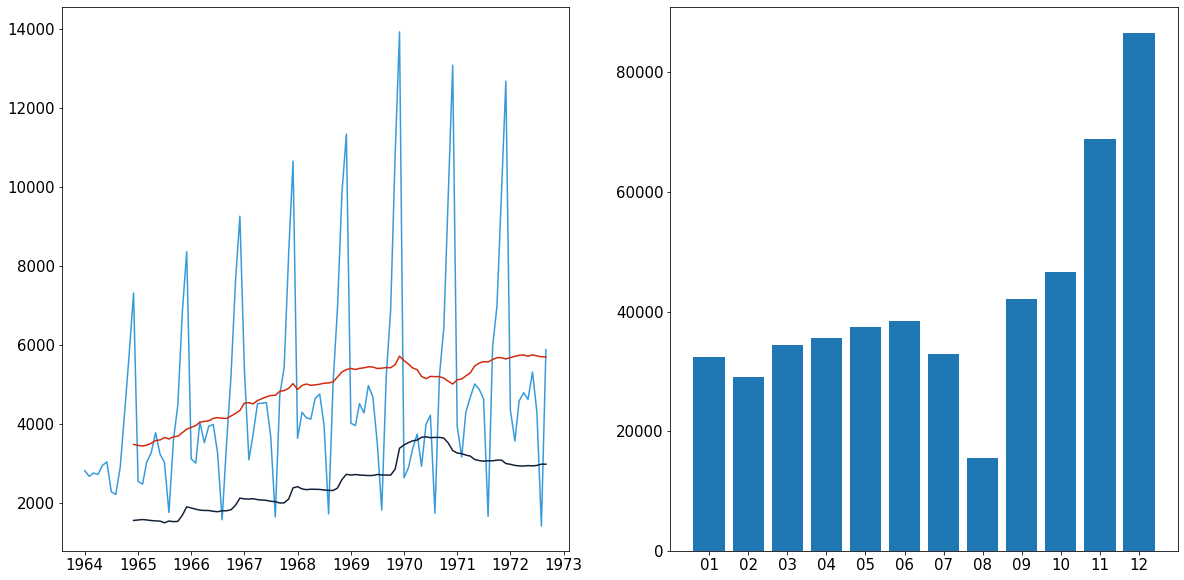

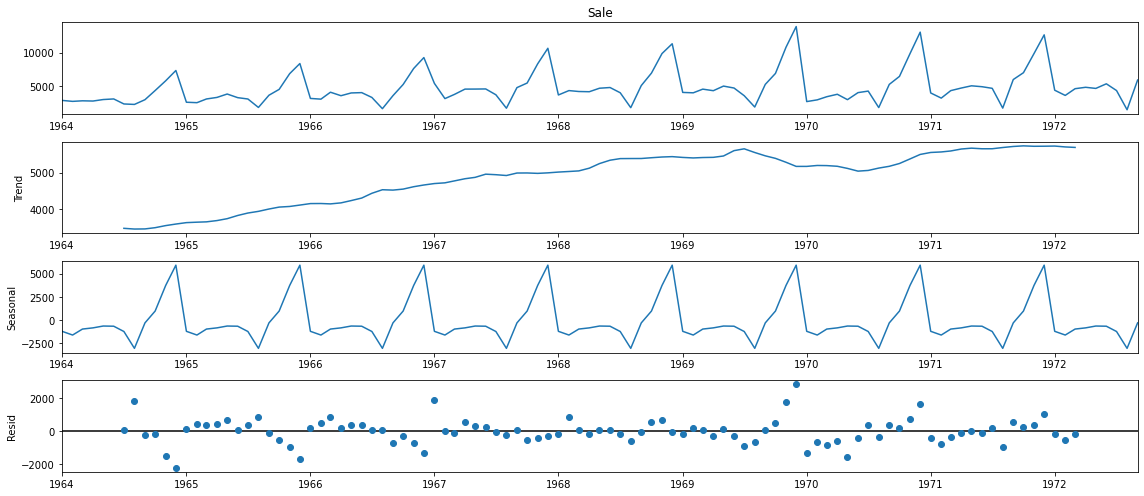

In [79]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(data["Sale"], color='#379BDB', label='Original')
plt.plot(data["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(data["rolling_std"], color='#142039', label='Rolling Std')
plt.subplot(1,2,2)
month = [str('%02d'%(i)) for i in range(1,13)]
cnt = [np.sum([r['Sale'] for idx, r in data.iterrows() if str(idx).split('-')[1]==d]) for d in month]# df['Sale'].values
plt.bar(month, cnt)

plt.rc("figure", figsize=(16, 7))
plt.rc("font", size=10)
fig = ssn.plot()
plt.show()

# Data stationarity test

In [80]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(data['Sale'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -1.833593
p-value                         0.363916
#Lags Used                     11.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


# Auto ARIMA

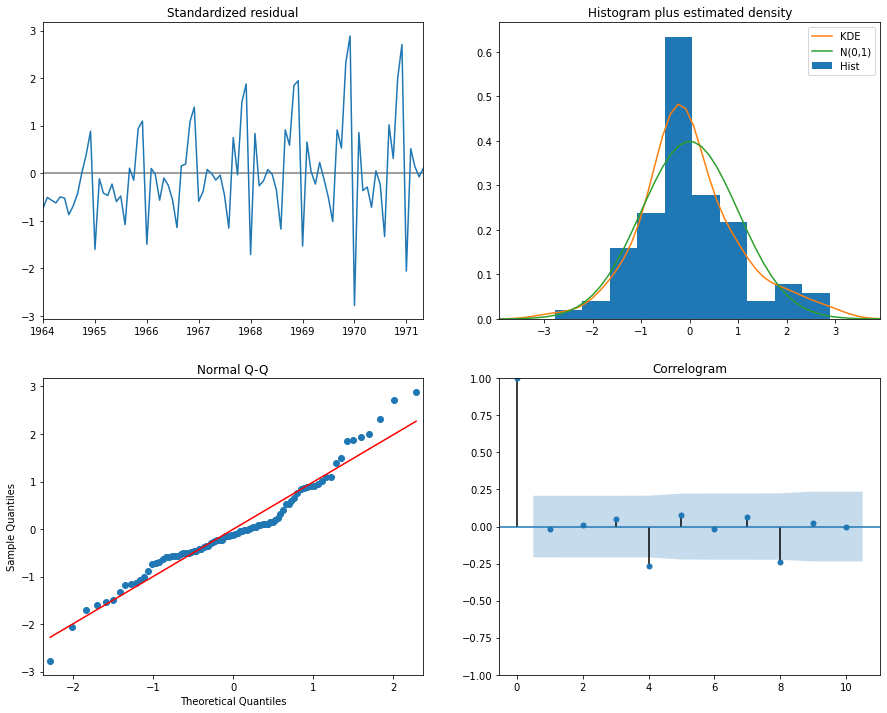

In [81]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['Sale'], 
                            start_p=1, 
                            start_q=1,
                            test='adf', # use adftest to find optimal 'd'
                            max_p=3, max_q=3, # maximum p and q
                            m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                            d=None,# let model determine 'd'
                            seasonal=False, # No Seasonality for standard ARIMA
                            trace=False, #logs 
                            error_action='warn', #shows errors ('ignore' silences these)
                            suppress_warnings=True,
                            stepwise=True)

ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

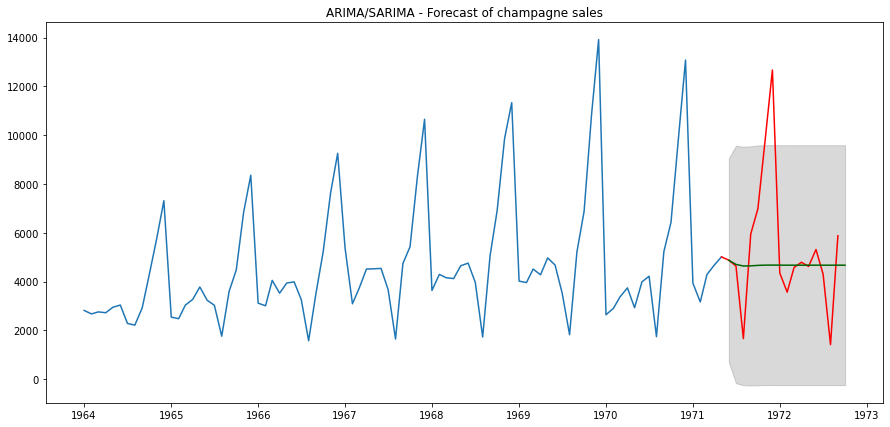

In [83]:
fitted_series, lower_series, upper_series = forecast(ARIMA_model, periods=df_test.shape[0])

plt.figure(figsize=(15,7))
plt.plot(df["Sale"], color='#1f76b4')
plt.plot(df_test["Sale"], color='red')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title("ARIMA/SARIMA - Forecast of champagne sales")
plt.show()

# Auto SARIMA

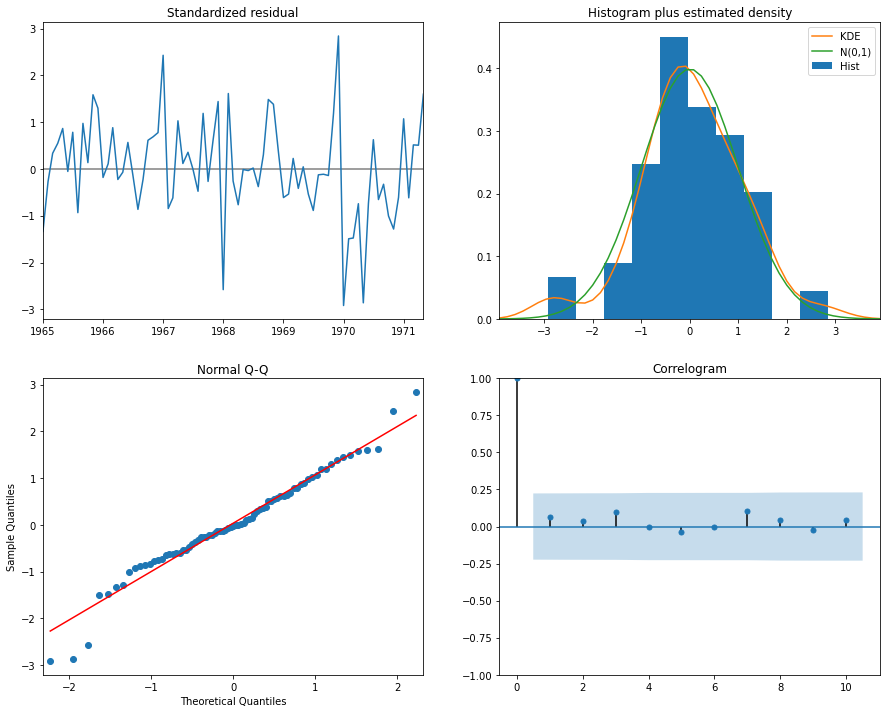

In [85]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["Sale"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

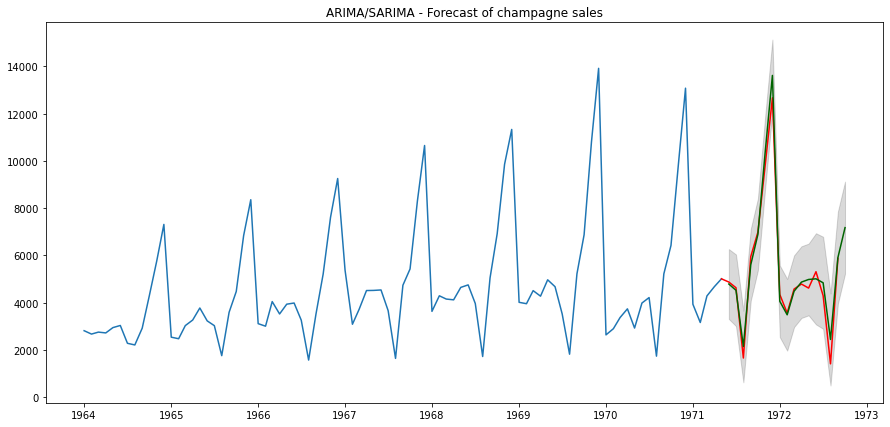

In [86]:
fitted_series, lower_series, upper_series = forecast(SARIMA_model, periods=df_test.shape[0])

plt.figure(figsize=(15,7))
plt.plot(df["Sale"], color='#1f76b4')
plt.plot(df_test["Sale"], color='red')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title("ARIMA/SARIMA - Forecast of champagne sales")
plt.show()

# Auto SARIMAX

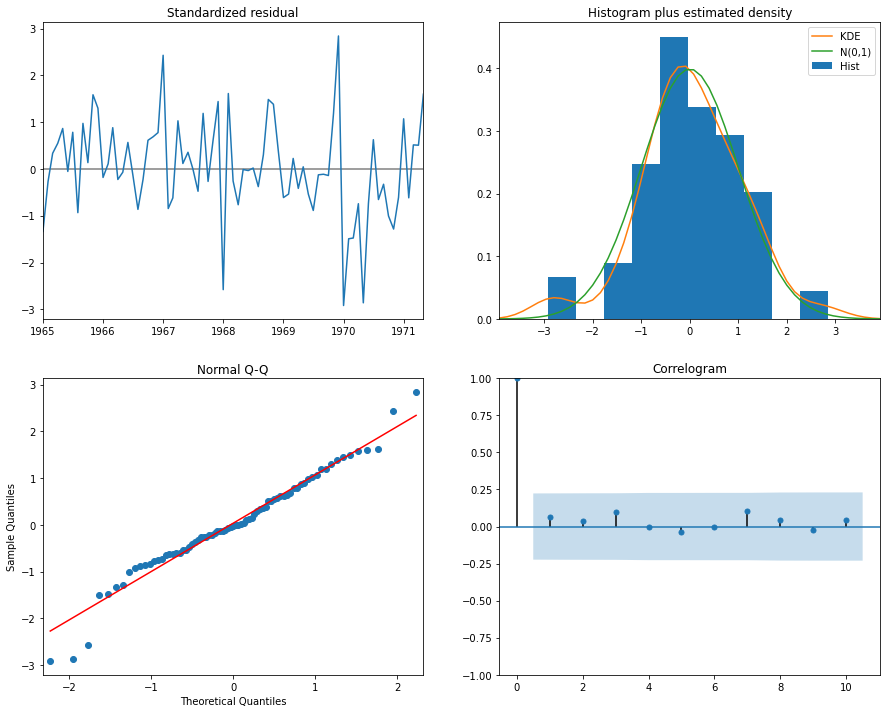

In [87]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df[['Sale']],
                              exogenous=df[['month_index']],
                              start_p=1, start_q=1,
                              test='adf',
                              max_p=3, max_q=3, m=12,
                              start_P=0, seasonal=True,
                              d=None, D=1, 
                              trace=False,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)

SARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

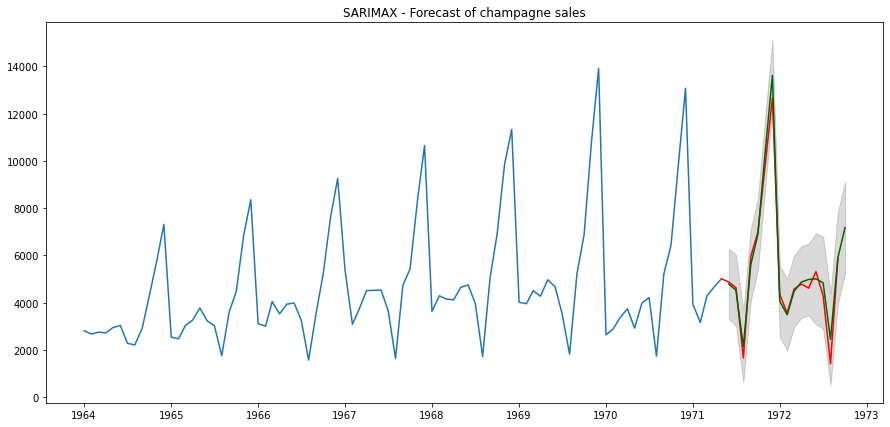

In [88]:
fitted_series, lower_series, upper_series = sarimax_forecast(SARIMAX_model, periods=df_test.shape[0])

plt.figure(figsize=(15,7))
plt.plot(df["Sale"], color='#1f76b4')
plt.plot(df_test["Sale"], color='red')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title("SARIMAX - Forecast of champagne sales")
plt.show()

## Differencing
#### Since our data is non stationary there are methods to apply to make it stationary. 
###### In differencing approach we will shift some positions down and subtract to it depending on the behavior of the dataset. In this particular case we are talking of seasonal sales behaviour which we will apply to a annual period, meaning that we will do the difference for 12 positions in representation of the 12 months of the year.

In [89]:
# df['Shifted'] = df['Sale']-df['Sale'].shift(12)
# df.head()

In [90]:
# #Augmented Dickey–Fuller test:
# print('Results of Dickey Fuller Test:')
# dftest = adfuller(df['Shifted'].dropna(), autolag='AIC')

# dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
# for key,value in dftest[4].items():
#     dfoutput['Critical Value (%s)'%key] = value
    
# print(dfoutput)

In [91]:
def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test

In [92]:
seq_len = 60
dropout = 0.2
window_size = seq_len - 1
batch_size = 16

In [93]:
scaler = MinMaxScaler()
price = df['Sale'].values.reshape(-1, 1)
scaled_price = scaler.fit_transform(price)

X_train, y_train, X, y = get_train_test_sets(scaled_price, seq_len, train_frac=0.8)
X_val, X_test = X[:int(X.shape[0]/2),:,:], X[int(X.shape[0]/2):,:,:]
y_val, y_test = y[:int(X.shape[0]/2),:], y[int(X.shape[0]/2):,:]

In [94]:
callbacks_list = [EarlyStopping(patience=20),
                  ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.2,
                                    patience=5,
                                    min_lr=0.001)]
metrics = [MeanSquaredError(), MeanAbsoluteError()]

In [95]:
# build a 3-layer LSTM RNN
model = keras.Sequential()
model.add(LSTM(window_size, return_sequences=True, input_shape=(window_size, X_train.shape[-1])))
model.add(Dropout(rate=dropout))# Bidirectional allows for training of sequence data forwards and backwards
model.add(Bidirectional(LSTM((window_size * 2), return_sequences=True))) 
model.add(Dropout(rate=dropout))
model.add(Bidirectional(LSTM(window_size, return_sequences=False))) 
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = metrics)

In [96]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=batch_size,
                    shuffle=False,
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val),
                    verbose=0)

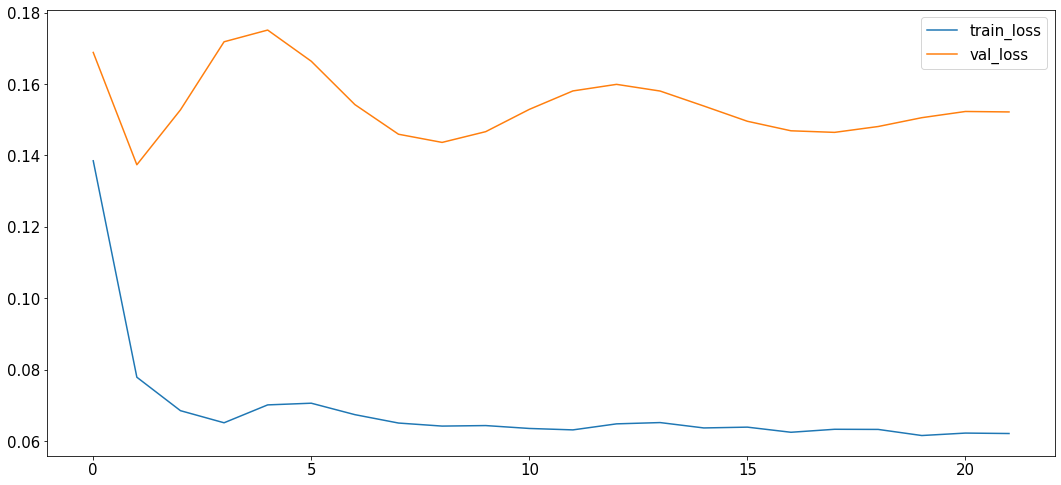

In [98]:
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 15})

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.tight_layout()

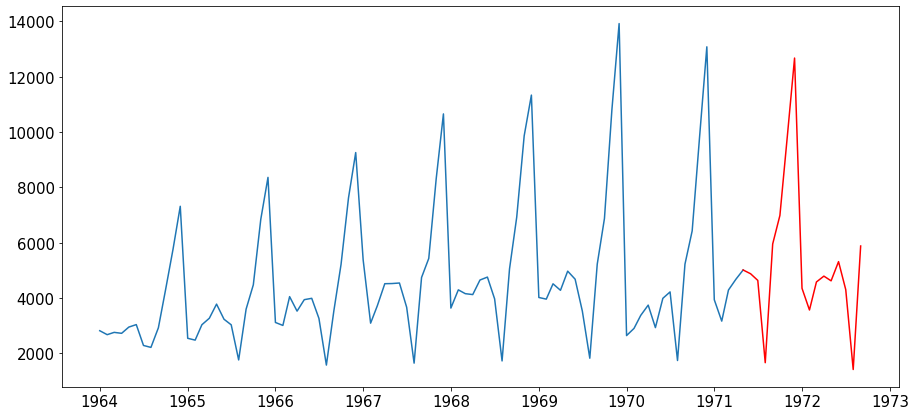

(3, 1)

In [102]:
y_pred = scaler.inverse_transform(model.predict(X_test))

plt.figure(figsize=(15,7))
plt.plot(df["Sale"], color='#1f76b4')
plt.plot(df_test["Sale"], color='red')
# plt.plot(, color='darkgreen')
plt.show()
# plt.plot(df.iloc[,'Sale'], color='#1f76b4', label='Historical occurence')
# plt.plot(df_test["Sale"], color='red', label='Actual occurence')
# plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='darkgreen', label='Predicted occurence')
y_pred.shape
# plt.legend()
# plt.show()

In [101]:
df_test.shape

(17, 3)

In [103]:
X_test.shape

(3, 59, 1)